# Universal Bank Project

In [171]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline


from dmba import gainsChart, liftChart
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [172]:
universal_bank = pd.read_csv("Universal_Bank.csv") #importing dataset

In [173]:
universal_bank.head()

universal_bank.columns = [x.strip().replace(' ', '_') for x in universal_bank.columns] #Modifying the column titles

universal_bank
print("Number of unique values in ID column:",universal_bank.ID.nunique(),
      "\nTotal count of ID column:",universal_bank.ID.count())
universal_bank.set_index('ID',inplace=True) #given that each ID is unique it can be set as the index
universal_bank

Number of unique values in ID column: 5000 
Total count of ID column: 5000


,Age,Experience,Income,ZIP_Code,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
ID,,,,,,,,,,,,,
1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,29,3,40,92697,1,1.9,3,0,0,0,0,1,0
4997,30,4,15,92037,4,0.4,1,85,0,0,0,1,0
4998,63,39,24,93023,2,0.3,3,0,0,0,0,0,0


#### understand the dataset using data visualization. 

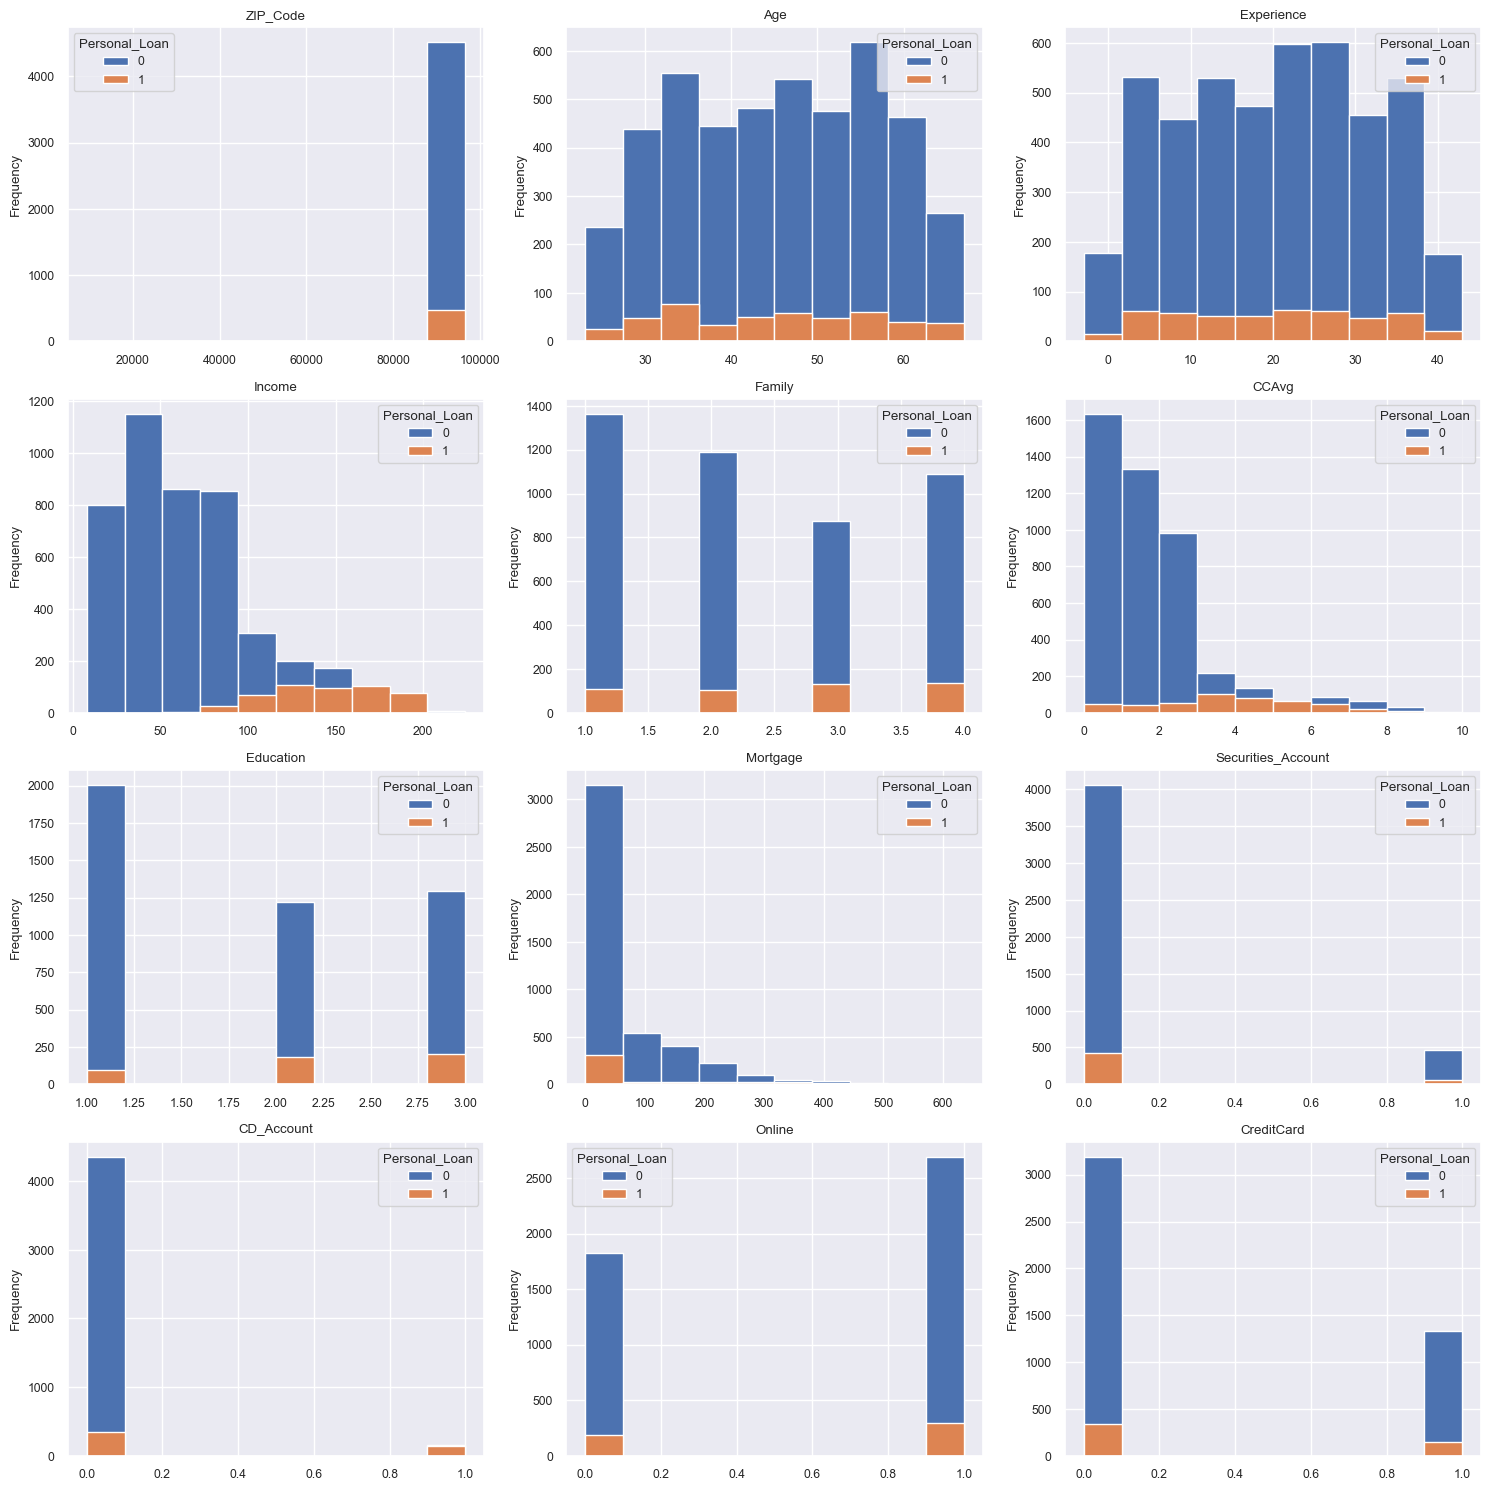

In [174]:
#Showing the frequency of each column and color-coding the personal loan to comprehend its distribution.
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
columns = ['ZIP_Code', 'Age', 'Experience', 'Income', 'Family', 'CCAvg', 'Education', 'Mortgage',
          'Securities_Account', 'CD_Account','Online', 'CreditCard']
for i, column in enumerate(columns):
    universal_bank.pivot(columns='Personal_Loan',values=column).plot(kind='hist',title=column,ax=axes[i // 3, i % 3]) 
plt.tight_layout()

#### Inspecting Data:
* Identifying missing values
* understanding data types 
* Determining which information or columns are useful for analysis

In [175]:
print("Sum of Missing Values:\n", universal_bank.isna().sum())

Sum of Missing Values:
 Age                   0
Experience            0
Income                0
ZIP_Code              0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal_Loan         0
Securities_Account    0
CD_Account            0
Online                0
CreditCard            0
dtype: int64


In [176]:
print("Data Types: \n",universal_bank.dtypes)

Data Types: 
 Age                     int64
Experience              int64
Income                  int64
ZIP_Code                int64
Family                  int64
CCAvg                 float64
Education               int64
Mortgage                int64
Personal_Loan           int64
Securities_Account      int64
CD_Account              int64
Online                  int64
CreditCard              int64
dtype: object


In [177]:
#Removing columns based on the visualization of the histograms,it isn't useful.
universal_bank = universal_bank.drop(columns=['ZIP_Code']) 

In [178]:
universal_bank.describe().T.round(1)

,count,mean,std,min,25%,50%,75%,max
Age,5000.0,45.3,11.5,23.0,35.0,45.0,55.0,67.0
Experience,5000.0,20.1,11.5,-3.0,10.0,20.0,30.0,43.0
Income,5000.0,73.8,46.0,8.0,39.0,64.0,98.0,224.0
Family,5000.0,2.4,1.1,1.0,1.0,2.0,3.0,4.0
CCAvg,5000.0,1.9,1.7,0.0,0.7,1.5,2.5,10.0
Education,5000.0,1.9,0.8,1.0,1.0,2.0,3.0,3.0
Mortgage,5000.0,56.5,101.7,0.0,0.0,0.0,101.0,635.0
Personal_Loan,5000.0,0.1,0.3,0.0,0.0,0.0,0.0,1.0
Securities_Account,5000.0,0.1,0.3,0.0,0.0,0.0,0.0,1.0
CD_Account,5000.0,0.1,0.2,0.0,0.0,0.0,0.0,1.0


In [179]:
#It's impossible to have a negative amount of work experience, therefore setting them to 0.
universal_bank.loc[universal_bank['Experience'] < 0]
print("Amount of negative experience: ",universal_bank.loc[universal_bank['Experience'] < 0].Experience.count())

universal_bank['Experience'] = np.where(universal_bank['Experience'] < 0, 0, universal_bank['Experience'])

print("Amount of Negative experience after removing them: ",universal_bank.loc[universal_bank['Experience'] < 0].Experience.count())

Amount of negative experience:  52
Amount of Negative experience after removing them:  0


#### Functions:
* get_accuracy - accuracy of the model used, and a confusion matrix displays data.
* gains_lift_chart - uses data visualization to analyse the model when targeting a certain portion of the dataset:
    * Cumulative gains - positive outcomes relative to the cumulative population percentage, sorted by predicted probabilities.
    * lift chart - compares the performance of the model against a random selection.
* profit_calculation - creates a dataset that utilizes the predicted outcome to determine the individuals to contact, the ID of consumers is provided. Furthermore, it provides a summary of the financial gains or losses, accuracy, number of customers to reach out, and comments.

In [180]:
def get_accuracy(train_X, train_y, valid_X, valid_y, model,model_name=''):
    
    if model_name == '':
        model_name = model

    model.fit(train_X, train_y)
    #calculate accuracy
    print('{0} Training Set Accuracy:'.format(model_name), 
          '{:.2%}'.format(accuracy_score(train_y, model.predict(train_X))))
    print('{0} Test Set Accuracy:'.format(model_name),
          '{:.2%}'.format(accuracy_score(valid_y, model.predict(valid_X))))

    
    #create confusion matrix
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,3.5), tight_layout=True)
    sns.set(font_scale=0.8)
    a = sns.heatmap(confusion_matrix(train_y, model.predict(train_X),labels=model.classes_),
                annot=True,annot_kws={'size': 20},fmt="n",ax = ax1,cmap="YlGnBu",
                xticklabels=['Rejected Loan','Accepted Loan'],
                yticklabels=['Rejected Loan','Accepted Loan'])
    a.set_xlabel('Predicted Values', fontsize=13)
    a.set_ylabel('Actual Values', fontsize=13)
    a.set_title('Training Set', fontsize=15)

    b = sns.heatmap(confusion_matrix(valid_y,model.predict(valid_X),labels=model.classes_),
                    annot=True,annot_kws={'size': 20},fmt="n",ax = ax2,cmap="YlGnBu",
                    xticklabels=['Rejected Loan','Accepted Loan'],
                    yticklabels=['Rejected Loan','Accepted Loan'])
    b.set_xlabel('Predicted Values', fontsize=13)
    b.set_ylabel('Actual Values', fontsize=13)
    b.set_title('Test Set', fontsize=15)
    
    
    plt.suptitle('{0} Confusion Matrix:'.format(model_name),fontsize = 18)
    plt.show()

In [181]:
def gains_lift_chart(pred_probability,model_name=''):

    predv_df = pd.DataFrame(pred_probability).sort_values(by=1, ascending=False)
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4), tight_layout=True)
    
    a = gainsChart(predv_df[1], ax = ax1)
    a.set_title('Cumulative Gains Chart', fontsize=15)
    
    b = liftChart(predv_df[1],  ax = ax2)
    b.set_title('Decile Lift Chart', fontsize=15)
    
    
    plt.suptitle('{0} Model Evaluation: Cumulative Gains & Decile Lift Charts'.format(model_name),fontsize = 18)
    plt.show()

In [182]:
def profit_calculation(df_x, df_y, model,comment = ""):

    model_prob = model.predict(df_x) #calculating the models probability

    df_profit = pd.DataFrame(index = universal_bank.index)
    df_profit['actual']=df_y
    df_profit['prediction']=model_prob
    

    #Removing all rows where the loan prediction is zero given that we won't reach out to those customers
    df_profit = df_profit.drop(df_profit[df_profit['prediction']==0].index)
    
    #loss when rejecting the loan: -$1 - $105 - $35 = -$141
    #the profit when accepting the loan: $1,000 - $141 = 859 
    df_profit['profit'] = np.where(df_profit['actual'] == 1, 859, -141)
    #Given that we are taking the max for net profit, we want the nagative values before the positive
    df_profit.sort_values(by=['actual'], inplace=True, ascending=True)
    df_profit['cum_profit'] = np.cumsum(df_profit.profit)

    accuracy = accuracy_score(df_y, model_prob)#need to use original data given df_profit has many removed values
    accuracy = "{}%".format((accuracy*100).round(1))#round to 1 decimel
    net_profit = "${:,.2f}".format(df_profit.cum_profit.max())
    count_letterssent = df_profit.cum_profit.count()
    total_loss = count_letterssent*141 #every person we reach out to we lose a total of 141
    total_loss = '${:,.2f}'.format(total_loss) 
    Revenue = df_profit.loc[df_profit['actual']==1].actual.count()*1000
    Revenue = '${:,.2f}'.format(Revenue) 
    
    #loan acceptance rate = based on the model's predictions of accounts that accepted the loan
    Percentage_acceptance_Loan = "{}%".format((df_profit.loc[df_profit['actual']==1].actual.count()
                                               /count_letterssent*100).round(1))
                                                 
    
    print(df_profit)#printing dataset
    
    return[accuracy,net_profit, Percentage_acceptance_Loan, count_letterssent, total_loss,Revenue, comment]



#create dataframe with results
model_results = pd.DataFrame(columns = ('Model_Accuracy','Net_Profit','Loan_Acceptance_Rate','No_Letters_sent',
                                        'Cost','Revenue','Comment'))

#### data partitioning 
split data into training and testing set

In [183]:
df_x = universal_bank.drop(columns=['Personal_Loan'])
df_y = universal_bank[['Personal_Loan']]

scaler = StandardScaler() #normalizing the data
scaler.fit(df_x)
df_x = scaler.transform(df_x)
df_x

array([[-1.77441684, -1.67139016, -0.53822878, ..., -0.25354028,
        -1.21661774, -0.64531434],
       [-0.02952359, -0.09787278, -0.8641094 , ..., -0.25354028,
        -1.21661774, -0.64531434],
       [-0.55299157, -0.44754331, -1.36379301, ..., -0.25354028,
        -1.21661774, -0.64531434],
       ...,
       [ 1.54088033,  1.65047986, -1.08136314, ..., -0.25354028,
        -1.21661774, -0.64531434],
       [ 1.71536965,  1.73789749, -0.53822878, ..., -0.25354028,
         0.82195086, -0.64531434],
       [-1.51268285, -1.40913726,  0.20043396, ..., -0.25354028,
         0.82195086,  1.54963239]])

#### Full Dataset Analysis

In [184]:
#reaching out to everyone in the dataset
df_actual = pd.DataFrame()
df_actual['actual']=df_y
df_actual['profit'] = np.where(df_actual['actual'] == 1, 859, -141)
df_actual.sort_values(by=['actual'], inplace=True, ascending=True)
#Half the applicants accept the loan, incurring setup and procedural fees, while the remaining half only have mailing costs
#note: not all individuals who accept the loan actually utilize it, resulting in greater losses for those accounts.
df_actual.iloc[0:2500, 1:2]=-1 
df_actual['cum_profit'] = np.cumsum(df_actual.profit)
df_actual.iloc[2495:2555]

,actual,profit,cum_profit
ID,,,
911,0,-1,-2496
910,0,-1,-2497
909,0,-1,-2498
908,0,-1,-2499
907,0,-1,-2500
913,0,-141,-2641
906,0,-141,-2782
904,0,-141,-2923
903,0,-141,-3064


In [185]:
total_dataset_count = df_actual.actual.count()
accepted_loan_count = df_actual.loc[df_actual['actual']==1].actual.count()
print("Number of customers in the dataset: ", total_dataset_count,"\n",
      "Number of customers that rejected the loan: ",df_actual.loc[df_actual['actual']==0].actual.count(),"\n",
      "Number of customers that utilized the loan: ",accepted_loan_count,
     "Percentage of customers utilized the loan: {}%".format(accepted_loan_count/total_dataset_count*100))

print("\n")

accepted_loan_not_used = (df_actual.actual.count()/2)-df_actual.loc[df_actual['actual']==1].actual.count()
accepted_loan_not_used_percentage = (accepted_loan_not_used/(df_actual.actual.count()/2)*100).round(2)
cost_proc_setup = df_actual.actual.count()/2*140


print("Every customer receives a mail letter at a cost of $1.00. Additionally, half of the customers accept the loan", 
      "resulting in a $140.00 charge for processing and setup. The charges are listed bellow: \n",
      "${:,.2f} mailing cost".format(total_dataset_count),
      "\n",
      "${:,.2f} processing and setup cost".format(cost_proc_setup),
      "\n",
      "{}% of customers accepted the loan but didn't utulize it".format(accepted_loan_not_used_percentage),
      "\n",
      "Cost of customers who accepted the loan but didn't use loan is ${:,.2f}".format(accepted_loan_not_used*141),"\n\n")

print("Total Cost is ${:,.2f}".format(total_dataset_count + cost_proc_setup),"\n",
     "Total Revenue is ${:,.2f}".format(accepted_loan_count*1000),"\n",
     "Net Profit is ${:,.2f}".format((accepted_loan_count*1000)-total_dataset_count-cost_proc_setup))

Number of customers in the dataset:  5000 
 Number of customers that rejected the loan:  4520 
 Number of customers that utilized the loan:  480 Percentage of customers utilized the loan: 9.6%


Every customer receives a mail letter at a cost of $1.00. Additionally, half of the customers accept the loan resulting in a $140.00 charge for processing and setup. The charges are listed bellow: 
 $5,000.00 mailing cost 
 $350,000.00 processing and setup cost 
 80.8% of customers accepted the loan but didn't utulize it 
 Cost of customers who accepted the loan but didn't use loan is $284,820.00 


Total Cost is $355,000.00 
 Total Revenue is $480,000.00 
 Net Profit is $125,000.00


In [186]:
model_results.loc['Full_dataset']=['{}%'.format(100), #accuracy
                                   '${:,.2f}'.format(df_actual.cum_profit.max()), #Net_Profit
                                   '{}%'.format((df_actual.loc[df_actual['actual']==1].actual.count()/df_actual.actual.count()*100).round(1)), #loan_acceptance_rate
                                   df_actual.cum_profit.count(), #No_Letters_sent
                                   '${:,.2f}'.format(((df_actual.loc[df_actual['actual']==0, 'profit'].sum()*-1)+ 
                                                      (df_actual.loc[df_actual['actual']==1].actual.count()*141))),#Cost
                                   '${:,.2f}'.format((df_actual.loc[df_actual['actual']==1].actual.count()*141)+
                                                    df_actual.loc[df_actual['actual']==1,'profit'].sum()),#Revenue
                                   "Includes all the Data"] #Comment

model_results

,Model_Accuracy,Net_Profit,Loan_Acceptance_Rate,No_Letters_sent,Cost,Revenue,Comment
Full_dataset,100%,"$125,000.00",9.6%,5000,"$355,000.00","$480,000.00",Includes all the Data


#### KNN model

In [187]:
knn_train_X, knn_valid_X, knn_train_y,  knn_valid_y = train_test_split(df_x, df_y, test_size=0.4,  random_state=1)

n_neighbors_df = []
for x in range(1, 12):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
    
    knn = KNeighborsClassifier(n_neighbors=x).fit(knn_train_X, knn_train_y)
    n_neighbors_df.append({'k': x,'accuracy': accuracy_score(knn_valid_y, knn.predict(knn_valid_X))})

n_neighbors_df = pd.DataFrame(n_neighbors_df)
#print(n_neighbors_df)


highest_accuracy = n_neighbors_df[n_neighbors_df['accuracy'] == n_neighbors_df['accuracy'].max()]['k'].iloc[0]
print("{} is the most accurate k value".format(highest_accuracy)) 

5 is the most accurate k value


In [188]:
knn = KNeighborsClassifier(n_neighbors=highest_accuracy) #perform knn classification on dataset
knn.fit(knn_train_X, knn_train_y)

knnProb = knn.predict_proba(knn_valid_X)
knnPred = knn.predict(knn_valid_X)

KNeighborsClassifier() Training Set Accuracy: 97.00%
KNeighborsClassifier() Test Set Accuracy: 95.70%


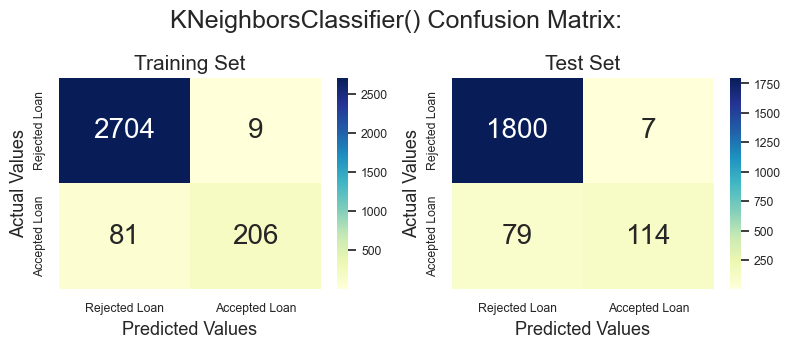

In [189]:
get_accuracy(knn_train_X, knn_train_y, knn_valid_X, knn_valid_y,knn)

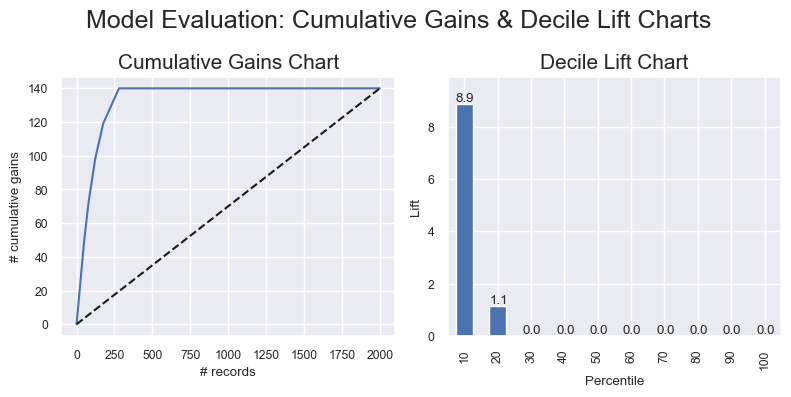

In [190]:
gains_lift_chart(knnProb)

In [191]:
model_results.loc['KNN'] = profit_calculation(df_x, df_y, knn)
model_results

      actual  prediction  profit  cum_profit
ID                                          
2666       0           1    -141        -141
2765       0           1    -141        -282
423        0           1    -141        -423
916        0           1    -141        -564
4571       0           1    -141        -705
...      ...         ...     ...         ...
1604       1           1     859      269188
1593       1           1     859      270047
1584       1           1     859      270906
1525       1           1     859      271765
4981       1           1     859      272624

[336 rows x 4 columns]


,Model_Accuracy,Net_Profit,Loan_Acceptance_Rate,No_Letters_sent,Cost,Revenue,Comment
Full_dataset,100%,"$125,000.00",9.6%,5000,"$355,000.00","$480,000.00",Includes all the Data
KNN,96.5%,"$272,624.00",95.2%,336,"$47,376.00","$320,000.00",


####  Naive Bayes 
using Multinomial NB 

In [192]:
Naive_bayes_df = universal_bank.copy()
Naive_bayes_df.nunique()

#will get dummies for columns greater than 2 and less than 5 unique values therefore, convert to category
for column in ('Family', 'Education'):
    Naive_bayes_df[column] = Naive_bayes_df[column].astype('category')

#for columns with many different values I am placing them into bins and converting to categories
Naive_bayes_df['Age'] = pd.cut(Naive_bayes_df['Age'], 5, labels=range(1, 6)).astype('category')
Naive_bayes_df['Experience'] = pd.cut(Naive_bayes_df['Experience'], 5, labels=range(1, 6)).astype('category')
Naive_bayes_df['Income'] = pd.cut(Naive_bayes_df['Income'], 8, labels=range(1, 9)).astype('category')
Naive_bayes_df['CCAvg'] = pd.cut(Naive_bayes_df['CCAvg'], 7, labels=range(1, 8)).astype('category')
Naive_bayes_df['Mortgage'] = pd.cut(Naive_bayes_df['Mortgage'], 10, labels=range(1, 11)).astype('category')

#Changing all values into binary data by obtaining dummy variables and creating multiple columns for each bin or group.
nb_X = pd.get_dummies(Naive_bayes_df.drop(columns=['Personal_Loan']))
nb_y = Naive_bayes_df[['Personal_Loan']]
nb_X.T

ID,1,2,3,4,5,6,7,8,9,10,...,4991,4992,4993,4994,4995,4996,4997,4998,4999,5000
Securities_Account,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CD_Account,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Online,0,0,0,0,0,1,1,0,1,0,...,0,0,0,1,1,1,1,0,1,1
CreditCard,0,0,0,0,1,0,0,1,0,0,...,1,1,0,0,0,0,0,0,0,1
Age_1,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,1,0,0,1
Age_2,0,0,1,1,1,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
Age_3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
Age_4,0,0,0,0,0,0,1,1,0,0,...,1,1,0,0,0,0,0,0,0,0
Age_5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0
Experience_1,1,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,1,1,0,0,1


In [193]:
nb_train_X, nb_valid_X, nb_train_y,  nb_valid_y = train_test_split(nb_X, nb_y, test_size=0.4,  random_state=1)

nb = MultinomialNB(fit_prior=False)
nb.fit(nb_train_X, nb_train_y)

nbProb = nb.predict_proba(nb_valid_X)
nbPred = nb.predict(nb_valid_X)

MultinomialNB(fit_prior=False) Training Set Accuracy: 88.93%
MultinomialNB(fit_prior=False) Test Set Accuracy: 87.35%


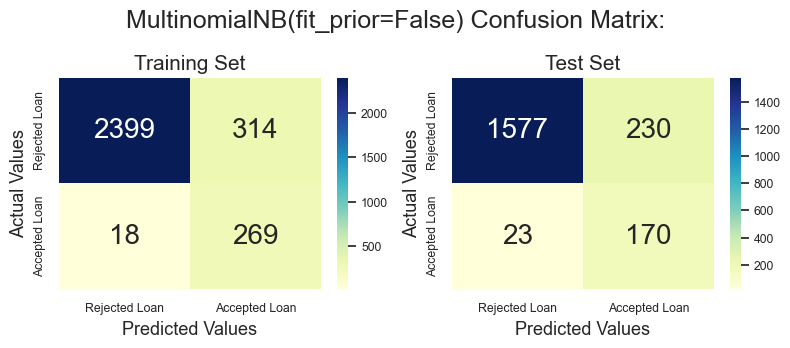

In [194]:
get_accuracy(nb_train_X, nb_train_y, nb_valid_X, nb_valid_y, nb)

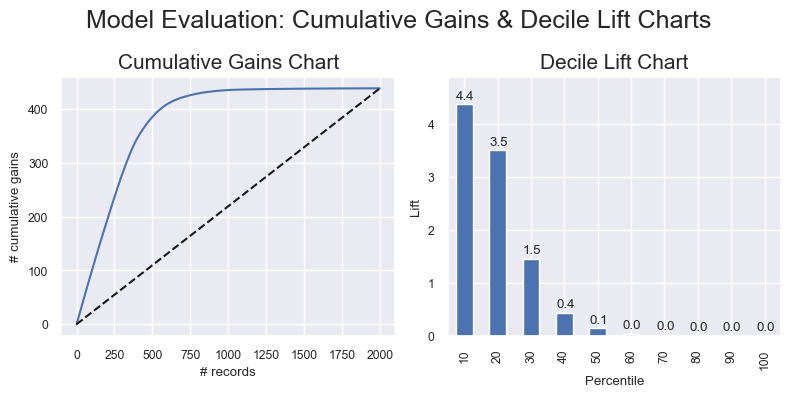

In [195]:
gains_lift_chart(nbProb)

In [196]:
model_results.loc['NB'] = profit_calculation(nb_X, nb_y, nb)
model_results

      actual  prediction  profit  cum_profit
ID                                          
4994       0           1    -141        -141
2156       0           1    -141        -282
3924       0           1    -141        -423
2175       0           1    -141        -564
2176       0           1    -141        -705
...      ...         ...     ...         ...
2247       1           1     859      296961
2262       1           1     859      297820
2268       1           1     859      298679
2197       1           1     859      299538
2478       1           1     859      300397

[983 rows x 4 columns]


,Model_Accuracy,Net_Profit,Loan_Acceptance_Rate,No_Letters_sent,Cost,Revenue,Comment
Full_dataset,100%,"$125,000.00",9.6%,5000,"$355,000.00","$480,000.00",Includes all the Data
KNN,96.5%,"$272,624.00",95.2%,336,"$47,376.00","$320,000.00",
NB,88.3%,"$300,397.00",44.7%,983,"$138,603.00","$439,000.00",


#### Decision Tree

In [197]:
dt_train_X, dt_valid_X, dt_train_y, dt_valid_y = train_test_split(df_x, df_y, test_size=0.4,  random_state=1)

dtc = DecisionTreeClassifier(random_state=1)
dtc.fit(dt_train_X, dt_train_y)

print('Tree has {} nodes'.format(dtc.tree_.node_count))

#testing different parameters to determine the best fit for the decision tree.
param_grid = {'max_depth': [5, 10, 15, 20, 25], 
        'min_impurity_decrease': [0, 0.001, 0.005, 0.01], 
        'min_samples_split': [10, 15, 20, 25, 30, 35, 40]}
gridSearch = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(dt_train_X, dt_train_y)
print('1st parameters: ', gridSearch.best_params_)

param_grid = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8], 
        'min_impurity_decrease': [0.0009, 0, 0.001, 0.0015, 0.002, 0.003, 0.004, 0.005], 
        'min_samples_split': [7, 8, 9, 10, 11, 12]}
gridSearch = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(dt_train_X, dt_train_y)
print('2nd parameters: ', gridSearch.best_params_)

bestRegTree = gridSearch.best_estimator_
#print(bestRegTree)


print('Tree has {} nodes'.format(bestRegTree.tree_.node_count))


dtc = bestRegTree
dtc.fit(dt_train_X, dt_train_y)

dtProb = dtc.predict_proba(dt_valid_X)
dtPred = dtc.predict(dt_valid_X)

Tree has 85 nodes
1st parameters:  {'max_depth': 5, 'min_impurity_decrease': 0, 'min_samples_split': 20}
2nd parameters:  {'max_depth': 7, 'min_impurity_decrease': 0, 'min_samples_split': 8}
Tree has 49 nodes


DecisionTreeClassifier(max_depth=7, min_impurity_decrease=0,
                       min_samples_split=8, random_state=1) Training Set Accuracy: 99.20%
DecisionTreeClassifier(max_depth=7, min_impurity_decrease=0,
                       min_samples_split=8, random_state=1) Test Set Accuracy: 97.90%


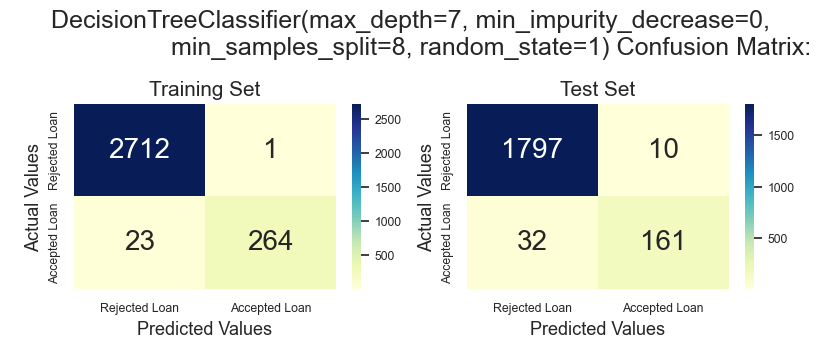

In [198]:
get_accuracy(dt_train_X, dt_train_y, dt_valid_X, dt_valid_y, dtc)

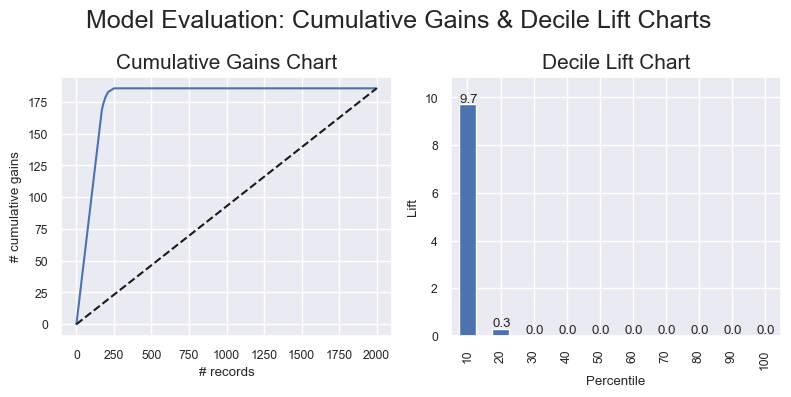

In [199]:
gains_lift_chart(dtProb)

In [200]:
model_results.loc['DT'] = profit_calculation(df_x, df_y, dtc)
model_results

      actual  prediction  profit  cum_profit
ID                                          
2983       0           1    -141        -141
1876       0           1    -141        -282
793        0           1    -141        -423
3309       0           1    -141        -564
4572       0           1    -141        -705
...      ...         ...     ...         ...
1604       1           1     859      360088
1593       1           1     859      360947
1590       1           1     859      361806
1653       1           1     859      362665
4981       1           1     859      363524

[436 rows x 4 columns]


,Model_Accuracy,Net_Profit,Loan_Acceptance_Rate,No_Letters_sent,Cost,Revenue,Comment
Full_dataset,100%,"$125,000.00",9.6%,5000,"$355,000.00","$480,000.00",Includes all the Data
KNN,96.5%,"$272,624.00",95.2%,336,"$47,376.00","$320,000.00",
NB,88.3%,"$300,397.00",44.7%,983,"$138,603.00","$439,000.00",
DT,98.7%,"$363,524.00",97.5%,436,"$61,476.00","$425,000.00",


#### Ensemble

In [201]:
ens_dataset = pd.DataFrame({'Personal_Loan': dt_valid_y.Personal_Loan.tolist(),
                             'knn_pred': knnPred, 'knn_prod': knnProb[:,1], 
                             'nb_pred': nbPred,  'nb_prod': nbProb[:,1], 
                             'dt_pred': dtPred, 'dt_prod': dtProb[:,1]})

ens_dataset['pred_mean'] = [1 if x > 0.5 else 0 for x in ens_dataset[['knn_pred','nb_pred','dt_pred']].mean(axis=1)]
ens_dataset['prob_mean'] = ens_dataset[['knn_prod','nb_prod','dt_prod']].mean(axis=1)#creating mean probability
ens_dataset['ds_mean'] = [1 if x > 0.5 else 0 for x in ens_dataset[['knn_pred','nb_pred','dt_pred','knn_prod',
                                                                    'nb_prod','dt_prod']].median(axis=1)]
ens_dataset.head(20)



,Personal_Loan,knn_pred,knn_prod,nb_pred,nb_prod,dt_pred,dt_prod,pred_mean,prob_mean,ds_mean
0,0,1,0.6,0,0.227182,0,0.000000,0,0.275727,0
1,0,0,0.0,0,0.000774,0,0.000000,0,0.000258,0
2,0,0,0.0,0,0.001626,0,0.000000,0,0.000542,0
3,0,0,0.0,0,0.165667,0,0.000000,0,0.055222,0
4,0,0,0.0,0,0.066998,0,0.000000,0,0.022333,0
5,0,0,0.0,0,0.007230,0,0.000000,0,0.002410,0
6,0,0,0.0,0,0.002415,0,0.000000,0,0.000805,0
7,0,0,0.0,0,0.434325,0,0.000000,0,0.144775,0
8,0,0,0.0,1,0.887316,0,0.214286,0,0.367200,0
9,0,0,0.4,1,0.839432,1,1.000000,1,0.746477,1


In [202]:
#accuracy scores
print("accuracy_dataset:",accuracy_score(ens_dataset.Personal_Loan,ens_dataset.ds_mean))
print("accuracy_pred:",accuracy_score(ens_dataset.Personal_Loan,ens_dataset.pred_mean))
ens_dataset['prob_mean'] = [1 if x > 0.5 else 0 for x in ens_dataset.prob_mean]
print("accuracy_prob:",accuracy_score(ens_dataset.Personal_Loan,ens_dataset.prob_mean))

accuracy_dataset: 0.974
accuracy_pred: 0.974
accuracy_prob: 0.9775


In [203]:
#given its only on test data we can't determine all the values in the dataset. 
model_results.loc['Ens'] = (('{}%'.format((accuracy_score(ens_dataset.Personal_Loan,ens_dataset.ds_mean)*100).round(1))),
                            np.nan,np.nan,np.nan,np.nan,np.nan,"Only validation dataset therefore n/a")

model_results

,Model_Accuracy,Net_Profit,Loan_Acceptance_Rate,No_Letters_sent,Cost,Revenue,Comment
Full_dataset,100%,"$125,000.00",9.6%,5000.0,"$355,000.00","$480,000.00",Includes all the Data
KNN,96.5%,"$272,624.00",95.2%,336.0,"$47,376.00","$320,000.00",
NB,88.3%,"$300,397.00",44.7%,983.0,"$138,603.00","$439,000.00",
DT,98.7%,"$363,524.00",97.5%,436.0,"$61,476.00","$425,000.00",
Ens,97.4%,NaN,NaN,NaN,NaN,NaN,Only validation dataset therefore n/a


#### Random Forest Classifier

In [204]:
rf_train_X, rf_valid_X, rf_train_y, rf_valid_y = train_test_split(df_x, df_y, test_size=0.4,  random_state=1)

random_forest = RandomForestClassifier(n_estimators=100, random_state=1)
random_forest.fit(rf_train_X, rf_train_y)


rfProb = random_forest.predict_proba(rf_valid_X)
rfPred = random_forest.predict(rf_valid_X)

RandomForestClassifier(random_state=1) Training Set Accuracy: 100.00%
RandomForestClassifier(random_state=1) Test Set Accuracy: 98.20%


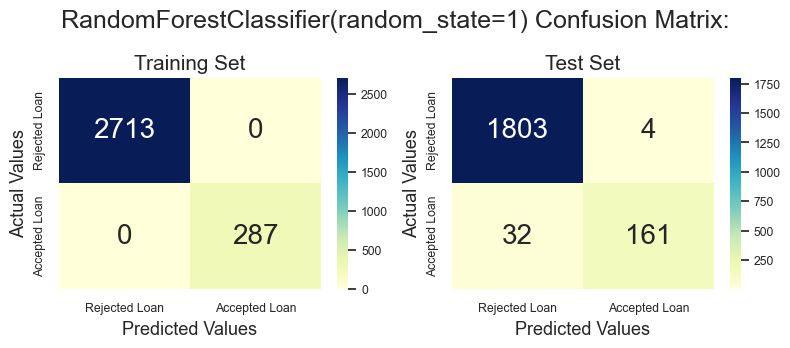

In [205]:
get_accuracy(rf_train_X,rf_train_y , rf_valid_X, rf_valid_y,random_forest)

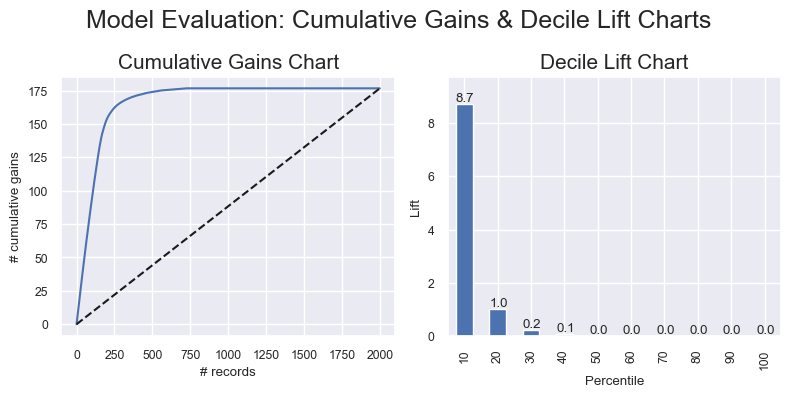

In [206]:
gains_lift_chart(rfProb)

In [207]:
model_results.loc['RF'] = profit_calculation(df_x, df_y, random_forest)
model_results

      actual  prediction  profit  cum_profit
ID                                          
3309       0           1    -141        -141
13         0           1    -141        -282
2739       0           1    -141        -423
2666       0           1    -141        -564
3296       1           1     859         295
...      ...         ...     ...         ...
1571       1           1     859      380832
1525       1           1     859      381691
1505       1           1     859      382550
1167       1           1     859      383409
4981       1           1     859      384268

[452 rows x 4 columns]


,Model_Accuracy,Net_Profit,Loan_Acceptance_Rate,No_Letters_sent,Cost,Revenue,Comment
Full_dataset,100%,"$125,000.00",9.6%,5000.0,"$355,000.00","$480,000.00",Includes all the Data
KNN,96.5%,"$272,624.00",95.2%,336.0,"$47,376.00","$320,000.00",
NB,88.3%,"$300,397.00",44.7%,983.0,"$138,603.00","$439,000.00",
DT,98.7%,"$363,524.00",97.5%,436.0,"$61,476.00","$425,000.00",
Ens,97.4%,NaN,NaN,NaN,NaN,NaN,Only validation dataset therefore n/a
RF,99.3%,"$384,268.00",99.1%,452.0,"$63,732.00","$448,000.00",


##### Models results

In [208]:
model_results

,Model_Accuracy,Net_Profit,Loan_Acceptance_Rate,No_Letters_sent,Cost,Revenue,Comment
Full_dataset,100%,"$125,000.00",9.6%,5000.0,"$355,000.00","$480,000.00",Includes all the Data
KNN,96.5%,"$272,624.00",95.2%,336.0,"$47,376.00","$320,000.00",
NB,88.3%,"$300,397.00",44.7%,983.0,"$138,603.00","$439,000.00",
DT,98.7%,"$363,524.00",97.5%,436.0,"$61,476.00","$425,000.00",
Ens,97.4%,NaN,NaN,NaN,NaN,NaN,Only validation dataset therefore n/a
RF,99.3%,"$384,268.00",99.1%,452.0,"$63,732.00","$448,000.00",


In [209]:
convert_columns = ['Net_Profit','Model_Accuracy','Loan_Acceptance_Rate','Cost','Revenue']
model_results.replace({'\$': '', '%': '', ',':''}, regex=True, inplace=True)
model_results[convert_columns] = model_results[convert_columns].astype(float)
model_results.dtypes
model_results

,Model_Accuracy,Net_Profit,Loan_Acceptance_Rate,No_Letters_sent,Cost,Revenue,Comment
Full_dataset,100.0,125000.0,9.6,5000.0,355000.0,480000.0,Includes all the Data
KNN,96.5,272624.0,95.2,336.0,47376.0,320000.0,
NB,88.3,300397.0,44.7,983.0,138603.0,439000.0,
DT,98.7,363524.0,97.5,436.0,61476.0,425000.0,
Ens,97.4,NaN,NaN,NaN,NaN,NaN,Only validation dataset therefore n/a
RF,99.3,384268.0,99.1,452.0,63732.0,448000.0,


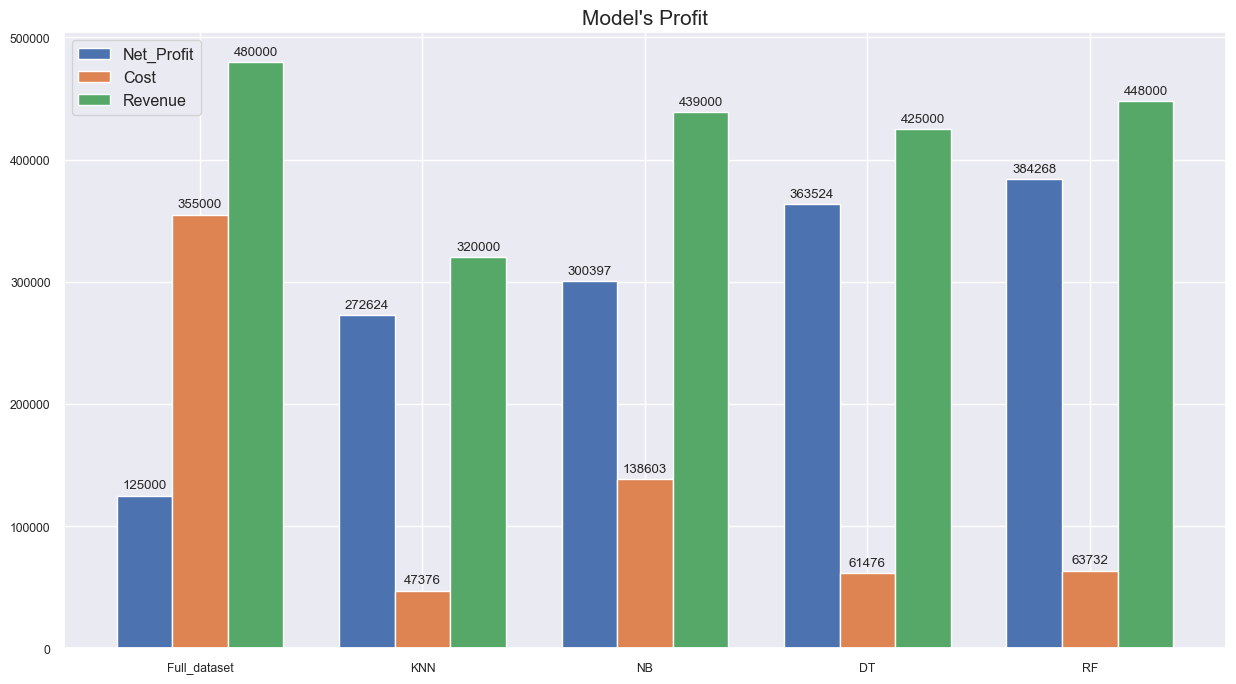

In [210]:
graph_profit = model_results.copy() 
graph_profit = graph_profit.drop(index = ['Ens'], columns = ['Model_Accuracy','Loan_Acceptance_Rate','No_Letters_sent',
                                                             'Comment'])
graph_profit = graph_profit.astype(float)
graph_profit.dtypes
graph_profit

#graph net_profit, cost, revenue
fig, ax = plt.subplots(figsize=(15, 8))

bar_width = 0.25
multiplier = 0
index = np.arange(len(graph_profit.index))

#adding all the data and the values of each column
for attribute, measurement in graph_profit.items():
    offset = bar_width * multiplier
    rects = ax.bar(index + offset, measurement, bar_width, label=attribute)
    ax.bar_label(rects ,padding=3)
    multiplier += 1
    
    
ax.set_title("Model's Profit", fontsize=15)
ax.set_xticks(index+bar_width, graph_profit.index) 
ax.legend(loc='upper left',fontsize ='large')

plt.show()


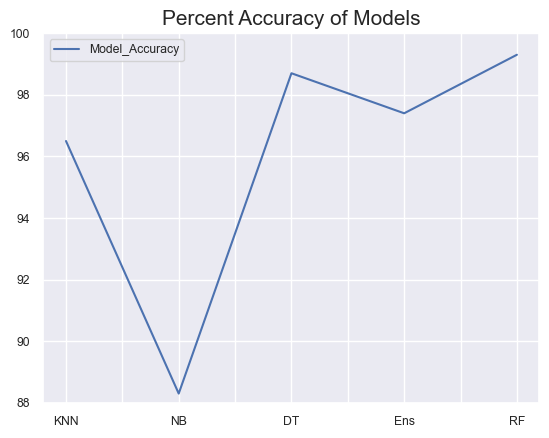

In [211]:
model_results.iloc[1:].plot(kind='line',y='Model_Accuracy').set_title('Percent Accuracy of Models', fontsize = 15)
plt.ylim(88,100)
plt.show()

##### Random Forest is best model 



In [212]:
model_results.iloc[5:]

,Model_Accuracy,Net_Profit,Loan_Acceptance_Rate,No_Letters_sent,Cost,Revenue,Comment
RF,99.3,384268.0,99.1,452.0,63732.0,448000.0,


Random Forest is the best perfoming model with a net profit of $384,268.00 the accuracy is 99.3% 

* cost = $63,732.00

* revenue = $448,000.00

* number of letters sent is 452 out of 5,000

* 99.1% of 452 people will accept the loan

In [213]:
#the mean value of all columns in the predicted dataset
RF_profit = universal_bank.copy()

dasfsdf = random_forest.predict(df_x)
RF_profit['prediction'] = dasfsdf
accuracy_score(RF_profit.Personal_Loan,RF_profit.prediction)
RF_profit

RF_profit = RF_profit.drop(RF_profit[RF_profit['prediction']==0].index)
    
RF_profit.drop(columns = 'prediction',inplace = True)

print("The mean value of all columns in the predicted dataset where it's forecasted that they will utilize the personal loan:\n",
      RF_profit.mean().round(2))

The mean value of all columns in the predicted dataset where it's forecasted that they will utilize the personal loan:
 Age                    45.03
Experience             19.80
Income                147.69
Family                  2.62
CCAvg                   3.98
Education               2.26
Mortgage              103.23
Personal_Loan           0.99
Securities_Account      0.12
CD_Account              0.29
Online                  0.62
CreditCard              0.30
dtype: float64
